# Finding the Next Bestseller

## Project Goal

Using publicly available data fom Goodreads, Wikipedia, and Amazon, this project aims to acquire, explore, and analyze information about books - their popularity via online reviews and ratings, as well as keywords, author name, publisher, and more - to programmatically determine which factors lead to a book landing on the New York Times Bestseller list. 

## Project Creators:

- [Brandon Navarrete](https://github.com/brandontnavarrete)
- [Magdalena Rahn](https://github.com/MagdalenaRahn)
- [Manuel Parra](https://github.com/manuelparra1)
- [Shawn Brown](https://github.com/shawn-brown12)


## Setting up the Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests
import unicodedata
import re
import os
import json

import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import nltk
#from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier as xgb

from scipy import stats

import prepare as prep
import explore as ex
import model as m

seed = 42

import warnings
warnings.filterwarnings("ignore")


## Acquisition

In [2]:
# This function sequentially runs each function from within the prepare.py file 
# in order to gather and clean the data, as well as creating our target variable and getting
# the sentiment analysis of the book summaries
# df = prep.prep_data('all_books.csv')

In [3]:
# a quick peak at our dataframe
# df.head()

In [4]:
# saving the above df into a new csv file, so that we don't have to run it through again unless we add to our dataset.
# df.to_csv('final_df.csv')

In [5]:
# pulling the data from the csv saved above
df = pd.read_csv('final_df.csv', index_col=0)

In [6]:
# a peak to compare the dataframe above and confirm they are the same
df.head()

,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,cleaned_title,cleaned_summary,successful,lemmatized_summary,neg,neutral,pos,compound,sentiment
0,Alice's Adventures in Wonderland: A Pop-Up Ada...,Alice's Adventures in Wonderland is Robert Sa...,2003,Robert Sabuda,157,26214,12.0,Classics,4.34,[],alice's adventures in wonderland a popup adapt...,alice's adventures in wonderland is robert sa...,False,alice adventure wonderland robert sabuda amaze...,0.000,0.627,0.373,0.9718,very positive
1,Just Me in the Tub,Taking a bath is a big job. Mercer Mayer's fam...,1994,Gina Mayer,62,19212,24.0,Childrens,4.25,[],just me in the tub,taking a bath is a big job. mercer mayer's fam...,False,take bath big job mercer mayer famous little c...,0.008,0.781,0.211,0.9811,very positive
2,The Rats in the Walls,"""The Rats in the Walls"" is a short story by H....",1924,H.P. Lovecraft,531,9155,25.0,Horror,4.01,[],the rats in the walls,the rats in the walls is a short story by h.p....,False,rat wall short lovecraft write augustseptember...,0.015,0.985,0.000,-0.1779,negative
4,Ralph S. Mouse by Beverly Cleary: Teacher Guide,"NOTE: This is not the book by Beverly Cleary, ...",2000,Gloria Levine,50,15889,28.0,Childrens,4.00,[],ralph s. mouse by beverly cleary teacher guide,"note this is not the book by beverly cleary, b...",False,note beverly cleary guide teacher accompany ti...,0.000,0.809,0.191,0.8570,very positive
7,The Hill We Climb: An Inaugural Poem for the C...,Librarian Note: Alternative Cover Edition for ...,2021,Amanda Gorman,2720,28125,29.0,Poetry,4.57,[],the hill we climb an inaugural poem for the co...,librarian note alternative cover edition for t...,False,librarian note alternative cover isbn january ...,0.000,0.784,0.216,0.9690,very positive


-----------------------------------------

### Data Summary

In [7]:
# our rows and columns
df.shape

(3665, 19)

In [8]:
# some basic information about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3665 entries, 0 to 3854
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               3665 non-null   object 
 1   summary             3665 non-null   object 
 2   year_published      3665 non-null   int64  
 3   author              3665 non-null   object 
 4   review_count        3665 non-null   int64  
 5   number_of_ratings   3665 non-null   int64  
 6   length              3665 non-null   float64
 7   genre               3665 non-null   object 
 8   rating              3665 non-null   float64
 9   reviews             1696 non-null   object 
 10  cleaned_title       3665 non-null   object 
 11  cleaned_summary     3665 non-null   object 
 12  successful          3665 non-null   bool   
 13  lemmatized_summary  3665 non-null   object 
 14  neg                 3665 non-null   float64
 15  neutral             3665 non-null   float64
 16  pos   

In [9]:
# a look at what genres we have
df['genre'].unique()

array(['Classics', 'Childrens', 'Horror', 'Poetry', 'Fantasy', 'Comics',
       'Romance', 'Young Adult', 'Biography', 'Fiction', 'Nonfiction',
       'Science Fiction', 'Thriller', 'Plays', 'Science', 'Short Stories',
       'Mystery', 'Philosophy', 'Humor', 'Paranormal', 'Christian',
       'History', 'Historical Fiction', 'Business', 'Graphic Novels',
       'Self Help', 'Psychology', 'Film', 'Memoir', 'Vampires', 'Music',
       'Travel', 'Urban Fantasy', 'Historical Romance', 'Chick Lit'],
      dtype=object)

## Preparation

In [10]:
# splitting our data into train and test subsets
train, test = ex.split(df, 'successful')

In [11]:
# checking the size of our subsets
train.shape, test.shape

((2932, 19), (733, 19))

<div class="alert alert-block alert-success">
<b>Acquisition and Preparation Takeaways</b>
    
- Initially, we had over 4000 books in our book list, as well at the dataset of NYT bestsellers comprising of over 1000 books. This included 11 features of each of those books. From the actual gathered data, we had around 3800 books, around 160 of which were bestsellers.
    
- For any null values in our data, we either imputed or dropped them, depending on what feature was null. We ended up dropping a number of rows where the summary was empty, while we manually imputed missing book titles, lengths, and publishing years, as those encompassed multiple of our bestsellers.
    
- We dropped any books not in English, as well as any duplicated books. We also used the Goodreads data on the first available hardcover edition, where possible.
    
- During our cleaning phase, we engineered a number of columns to our dataframe, including our target column, cleaned and lemmatized version, of the summary, and several values created during our dsentiment analysis of the summary.
    
- Our final dataframe had the following columns:
    - `title`, `summary`, `year_published`, `author`, `review_count`, `number_of_ratings`, `length`, `genre`, `rating`, `reviews`, `cleaned_title`, `cleaned_summary`, `target`, `lemmatized_summary`, `neg`, `neutral`, `pos`, `compound`, `sentiment`.


## Exploration

### Which words/ngrams appear more often in summaries with a positive sentiment?

(<AxesSubplot:title={'center':'Common Words in Positively Aligned Summaries'}, xlabel='Probability of Appearing', ylabel='Word'>, Text(0.5, 1.0, 'Common Words in Positively Aligned Summaries'), Text(0.5, 0, 'Probability of Appearing'), Text(0, 0.5, 'Word'), <matplotlib.legend.Legend object at 0x7fa3a5ea9220>)


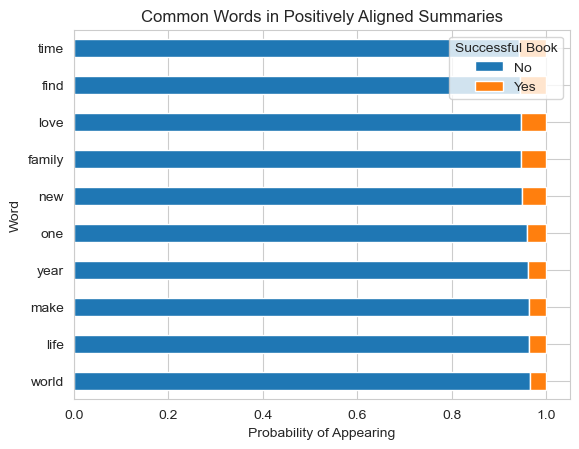

In [12]:
# function to most common single words
best_words = ex.uni_id_best_seller(train)

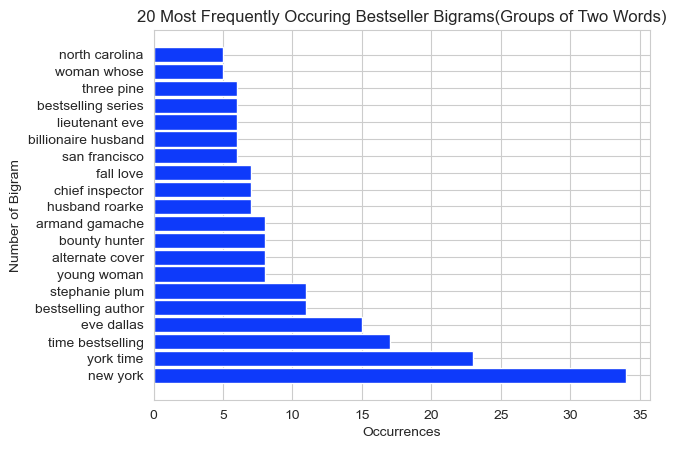

In [13]:
# function to show most common bigrams in bestsellers
ex.best_bigrams(best_words)

<div class="alert alert-block alert-success">
<b>Takeaways:</b> 
        
Looking at bi grams, we see:

----------------------------------------    

- 'bestselling author': Either the summary referencing a past bestseller or the fact that the book *is* a bestseller.
    
- 'bouny hunter': Perhaps books with bounty hunter characters are popular?

- There were a lot of character names, like: (eve, dallas(in death series)) or (armand, gamache(still life)(location three pine))  

- Sûreté du Québec is the provincial police service for the province of Quebec, in Canada.
    
</div>

### Which words/ngrams appear more often in summaries with a negative sentiment?

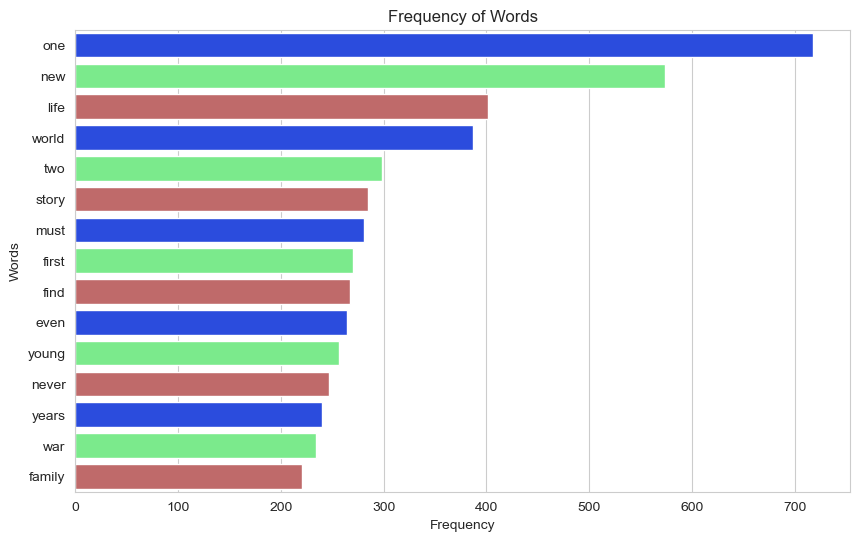

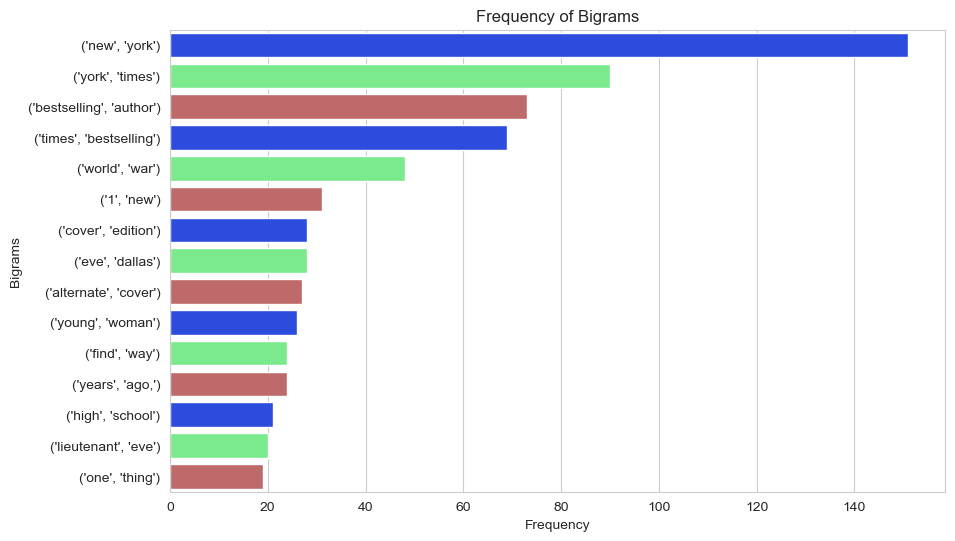

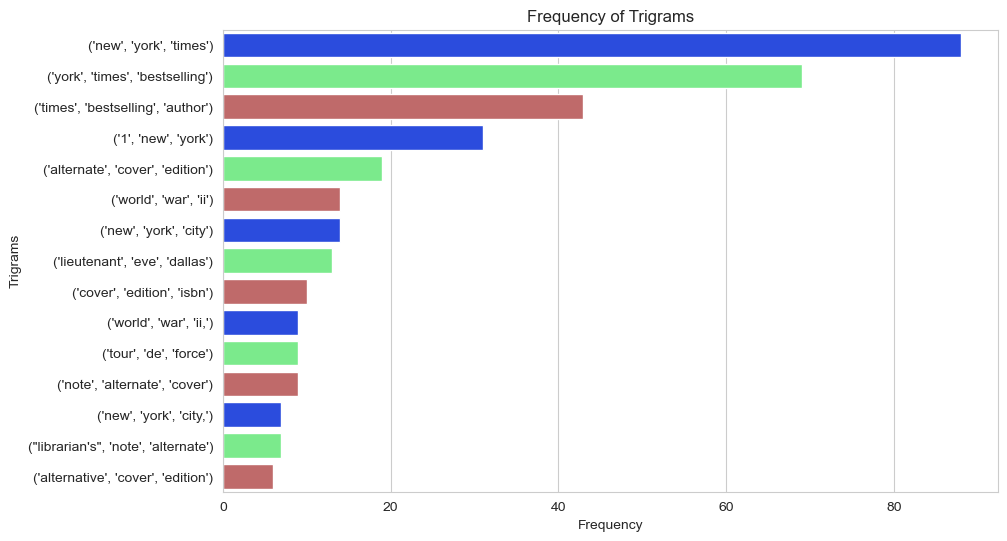

In [14]:
# function to check the frequency of top words, bigrams, and trigrams in summaries with negative sentiment
ex.explore_question_2(train)

<div class="alert alert-block alert-success">
<b>Takeaways</b>
    
Unigrams: 
    


### Is there a relationship between the length of a book and its appearing on the NYT Best Seller list?

Exploring length and successs:

$H_O$ : There is no relationship between the length of a book and its landing on the NYT Best Seller list.  
$H_a$ : There is a relationship between the length of a book and its landing on the NYT Best Seller list.

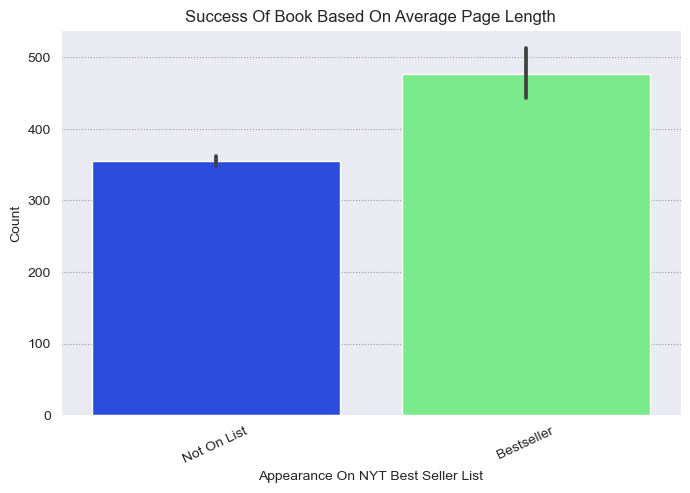

In [15]:
# function to visualize success vs book length
ex.book_len_success(train)

In [16]:
# defining two groups for chi squared function
a = train['length']
b = train['year_published']
#calling the chi squared function
ex.chi_sq(a, b)

--------------------------
Chi-square  : 95431.3919
P-value     : 0.0000
--------------------------
We reject the null hypothesis; there is a relationship between the target variable and the feature examined.


In [17]:
# same as above, defining groups for the chi squared test
r = train['length']
s = train['successful']
#calling the function for the chi squared test
ex.chi_sq(r, s)

--------------------------
Chi-square  : 788.2500
P-value     : 0.0000
--------------------------
We reject the null hypothesis; there is a relationship between the target variable and the feature examined.


<div class="alert alert-block alert-success">
<b>Takeaways</b>
    
There is a relationship between the length of the book (positive correlation) and the year that it was published, particularly for books not on the NYT Best Seller list, and for the train dataset. The length of the book and the year that it was published did not have a relationship for NYT Best Sellers

### What is the relationship between summary sentiment score and book length?

$H_0$ : There is no relationship between the books length and the summary's sentiment score.  
$H_a$ : There is some kind of relationship between the book length and the summary's sentiment score.

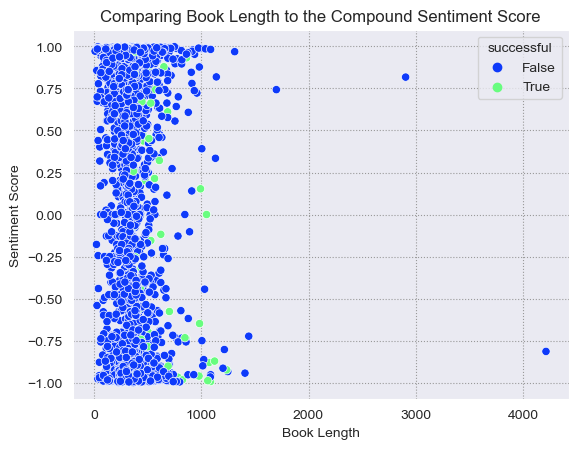

In [18]:
# function to call a visual created
ex.sent_vs_len(train)

In [19]:
# function to run a statistical test
ex.pearsonr_report(train['length'], train['compound'])

--------------------------
Correlation = -0.1108
p-value     = 0.0000
--------------------------
Is p-value < alpha? True


<div class="alert alert-block alert-success">
<b>Takeaways</b>
    
Going by the visual here we can see that, if there is a relationship here, it's pretty insignificant. After running a Pearson R statistical test on the two features, that is confirmed. We are able to reject the null hypothesis here that there isn't a relationship, but it **is** a weak relationship.

## Exploration Key Takeaways

<div class="alert alert-block alert-success">
<b>Key Takeaways</b>
    
- A lot of the most used words, bigrams, and trigrams had the words 'new', 'york', 'times', and 'bestseller', so on our next iteration we plan on creating a more robust set of stopwords.
    
- There is a weak positive correlation between book length and year published
    
- The book length and year published did not have a significant relationship with the success rate of a book when compared directly.
    
- There is weak negative relationship between the length of a book and the sentiment analysis of the book summary. 

## Modeling

### Preparing the data for modeling

In [20]:
# function to prep df for scaling and splitting by making dummies and removing uneeded categorical columns
df = m.ready_df(df)

In [21]:
df.head(1)

,review_count,number_of_ratings,length,genre,rating,successful,lemmatized_summary,neg,neutral,pos,...,genre_Short Stories,genre_Thriller,genre_Travel,genre_Urban Fantasy,genre_Vampires,genre_Young Adult,sentiment_neutral,sentiment_positive,sentiment_very negative,sentiment_very positive
0,157,26214,12.0,Classics,4.34,False,alice adventure wonderland robert sabuda amaze...,0.0,0.627,0.373,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# splitting df into train and test
train, test = ex.split(df, 'successful')

In [23]:
# a quick shape to check the sizes
train.shape, test.shape

((2932, 50), (733, 50))

In [24]:
# function to create our x/y subsets
X_train, y_train, X_test, y_test = m.Xy_set(train, test)

In [25]:
# a quick peak
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2932, 49), (2932,), (733, 49), (733,))

In [26]:
# a function to scale our numerical data
X_train_scaled, X_test_scaled = m.scaling(X_train, X_test)

In [27]:
X_train_scaled.head()

,"(review_count,)","(number_of_ratings,)","(length,)","(rating,)","(neg,)","(neutral,)","(pos,)","(compound,)",genre_Business,genre_Chick Lit,...,genre_Short Stories,genre_Thriller,genre_Travel,genre_Urban Fantasy,genre_Vampires,genre_Young Adult,sentiment_neutral,sentiment_positive,sentiment_very negative,sentiment_very positive
0,-0.392358,-0.284597,-0.114667,0.294094,0.109,0.798,0.093,-0.2431,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.024560,0.118897,0.098184,0.524097,0.133,0.828,0.039,-0.9093,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.274333,-0.061976,0.070178,-0.779255,0.082,0.774,0.144,0.8991,0,0,...,0,0,0,0,0,1,0,0,0,1
3,-0.352463,-0.291182,-0.798034,0.064090,0.080,0.920,0.000,-0.9238,0,0,...,0,0,0,0,0,1,0,0,1,0
4,-0.404869,-0.300636,0.423063,0.869102,0.303,0.635,0.062,-0.9702,0,0,...,0,0,0,0,0,0,0,0,1,0


### Model Evaluation

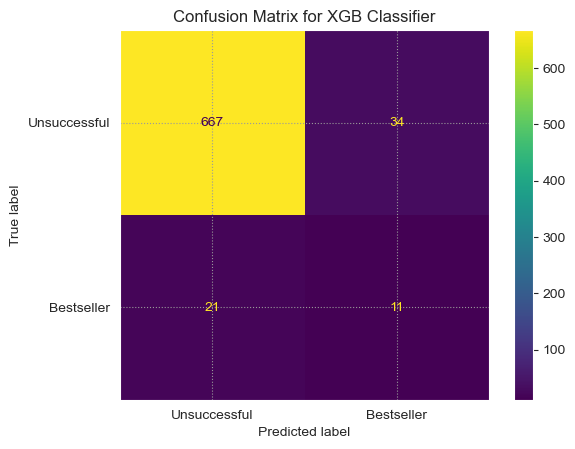

In [28]:
# function to 
y_pred = m.XGBclf(X_train_scaled, X_test_scaled, y_train, y_test)

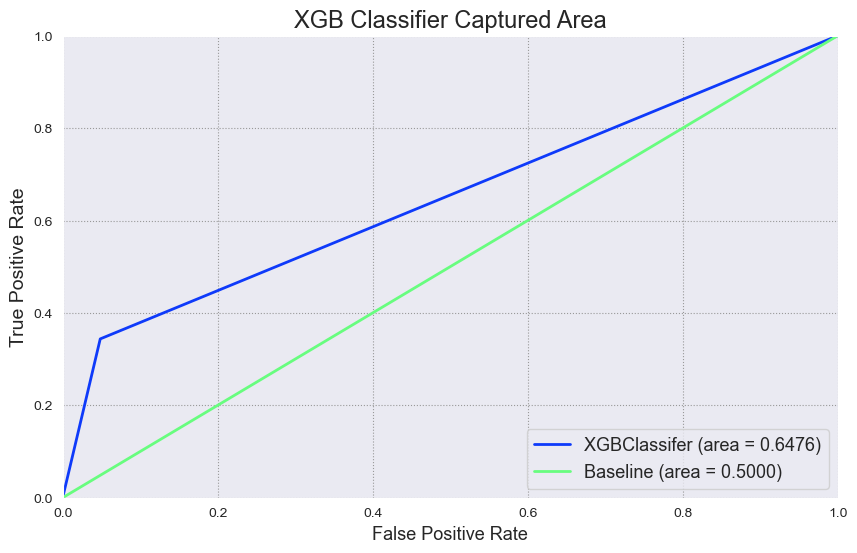

In [29]:
m.roc(y_test, y_pred)

<div class="alert alert-block alert-success">
<b>Takeaways</b>
    
- Our baseline recall was 0% and our accuracy 95%
    
- Through many iterations of XGBoost models, our best model gave us a recall of 34% and an accuracy of 96%.
    
- Overall, while there's room for improvement, we have beaten both of our baseline metrics.

## Conclusions

### Summary

<div class="alert alert-block alert-success">
<b></b>
    
- Our text data for the book summaries was not helpful in this iteration of the project. 

- We accurately predicted 11 of the 32 bestsellers in our test dataframe, giving us a recall score of 34.3%. 

- Our accuracy score was 96%, only missing 8 out of over 700 books in our test set.


### Recommendations

<div class="alert alert-block alert-success">
<b></b>
    
- Pay attention to the style of books written by authors whose books frequently appear on the New York Times Best Seller list.

- As a publisher, make efforts to get as many Goodreads ratings as possible, as the higher the number of reader ratings on Goodreads, the higher the overall star rating score and the more likely the book was to be on the New York Times Best Seller list.

### Next Steps

<div class="alert alert-block alert-success">
<b></b>
    
For future iterations of this project:
- Obtain the publishers of each book and multiple Goodreads user reviews for each book. 

    - This would be used for natural language processing (NLP) modeling on the text of the reviews. Feature engineering review sentiment scores would be another option.

    - Information on publishers would, likewise, be used as a feature in determining what contributes to a book being a NYT Best Seller title.
    
- Add a selection of new stopwords to try while cleaning the text data

- Model *seemed* to work better with a small selection of children's books, we would like to add those back in and find out why.